In [1]:
%run stdPackages.ipynb
os.chdir(d['py'])
import US_EulerModel_main, US_EulerModel_c, US_EulerModel_policy
os.chdir(d['curr'])

# Social Security Design for US (Euler, finite horizon): 
## Estimation of US model using 1980-2010 data

Load data and models:

In [2]:
with open(os.path.join(d['data'], 'USEuler2010_cals'), "rb") as file:
    pars2010 = pickle.load(file)
with open(os.path.join(d['data'], 'mUSEuler2010'), "rb") as file:
    m2010 = pickle.load(file)
with open(os.path.join(d['data'], 'USEuler1980_cals'), "rb") as file:
    pars1980 = pickle.load(file)
with open(os.path.join(d['data'], 'mUSEuler1980'), "rb") as file:
    m1980 = pickle.load(file)

### 1. Compare calibration of the two:

Extract combinations of $\rho, \xi$ for the two models:

In [3]:
pars1980_df = pd.concat([pd.Series([pars1980[k][kk] for k in pars1980], index = pd.Index(pars1980, name = 'ξ'), name = kk)
                         for kk in ('ρ','ω','β')], axis = 1)
pars2010_df = pd.concat([pd.Series([pars2010[k][kk] for k in pars2010], index = pd.Index(pars2010, name = 'ξ'), name = kk)
                         for kk in ('ρ','ω','β')], axis = 1)

Compare $\xi$:

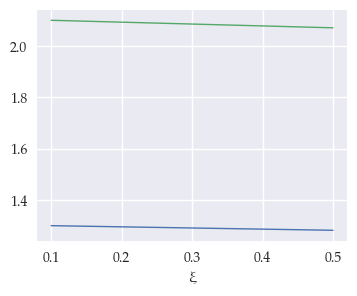

In [4]:
var = 'ρ'
fig, ax = plt.subplots(1,1,figsize = (4,3));
pars1980_df[var].plot(ax = ax, linewidth=1);
pars2010_df[var].plot(ax = ax, linewidth=1);

### 2. Impose 2010 calibration for 1980 model and simulate different solutions

#### 2.1. Solve and store full solution paths for all calibrated candidates

In [5]:
sols2010 = dict.fromkeys(pars2010)
for k,v in pars2010.items():
    m2010.db['ξ'] = k
    m2010.US_Xi() # update Xi after updating ξ
    m2010.db['ρ'] = v['ρ']
    m2010.db['ω'] = v['ω']
    m2010.db['βi'] = m2010.US_β(v['β'])
    sols2010[k] = m2010._getSolF()()

From a calibrated model get policy function:

In [7]:
m = m2010
policy = m.ESC.FH()

Get function of $\kappa$:

In [8]:
ineq = (m.db['ηi']**(1+m.db['ξ'])/(m.db['Xi']**m.db['ξ'])-1).reshape(m.ni,1)

In [9]:
s_ = sols2010[.1]['s[t-1]'].xs(2)
κ = np.linspace(0, 1, 51)
idx = 34

In [10]:
sol = policy[2]
solp = policy[3]
τ = 0.158
ν = m.db['ν'][2]
funcOfτ = {'s[t-1]': (sol['s_τ0']*(1-τ)**(-1/m.ESC.db['α']))[idx]}
funcOfτ['B'] = m.C.B(funcOfτ['s[t-1]'], sol['h'][idx], ν)
funcOfτ['Γs'] = m.C.Γs(funcOfτ['B'], τ, κ)

In [11]:
funcOfτ['si/s'] = m.C.savingsSpread(funcOfτ['B'], funcOfτ['Γs'], τ, κ)

Get marginal 

In [12]:
support = (m.db['αr'] * τ * ineq / (funcOfτ['si/s']+m.db['αr']*τ*(1+κ*ineq)))

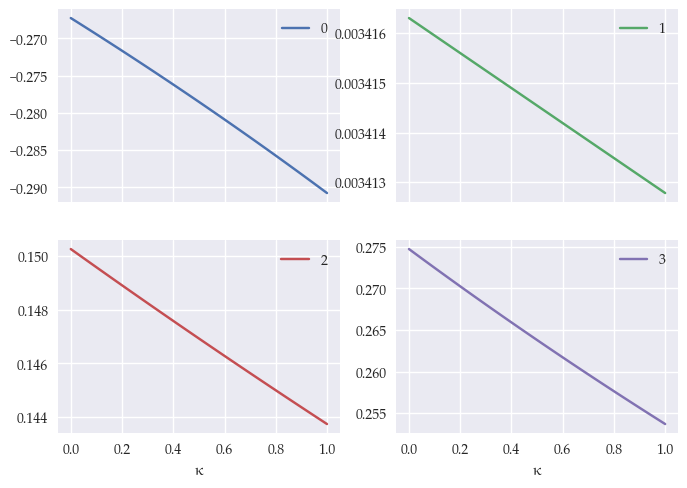

In [13]:
pd.DataFrame(support.T, index = pd.Index(κ, name = 'κ'), columns = m.db['i']).plot(subplots=True, layout = (2,2));

<Axes: >

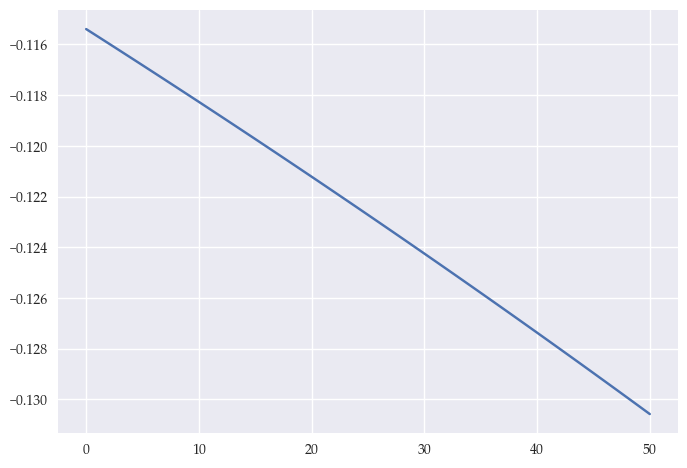

In [14]:
pd.Series(np.matmul(m.db['γi'], support)).plot()

For 1980:

In [15]:
sols1980 = dict.fromkeys(pars1980)
for k,v in pars1980.items():
    m1980.db['ξ'] = k
    m1980.US_Xi() # update Xi after updating ξ
    m1980.db['ρ'] = v['ρ']
    m1980.db['ω'] = v['ω']
    m1980.db['βi'] = m1980.US_β(v['β'])
    sols1980[k] = m1980._getSolF()()

#### 2.2. Set up 1980 model and solve for 2010 calibration options

In [7]:
data = {}
hours = np.array([2014.2, 2180.8, 2296.8, 2296.8]) # hours 
wagerates = np.array([6.20, 9.93, 15.17, 15.17]) # wages
income = hours*wagerates
data['zxi'] = hours/hours.mean()
data['zηi'] = income/income.mean()
data['pi'] = np.array([0.48314484, 0.6252, 0.697, 0.697]) # mortality rates

Initialize new model:

In [8]:
newData = m2010.db | data
mCF = US_EulerModel_main.Model(ngrid = m2010.ngrid, 
                               ni = m2010.ni, 
                               T = m2010.T, **newData)

Specify grid and solution strategies (from main models):

In [9]:
mCF.ESC.grids = m2010.ESC.grids.copy()

In [10]:
solsCF = dict.fromkeys(pars2010)
for k,v in pars2010.items():
    mCF.db['ξ'] = k
    mCF.US_Xi() # update Xi after updating ξ
    mCF.db['ρ'] = v['ρ']
    mCF.db['ω'] = v['ω']
    mCF.db['βi'] = mCF.US_β(v['β'])
    solsCF[k] = mCF._getSolF()()

Find best match measured in 2010 tax rates and plot comparison for highest, lowest + best fit:

<Axes: xlabel='t'>

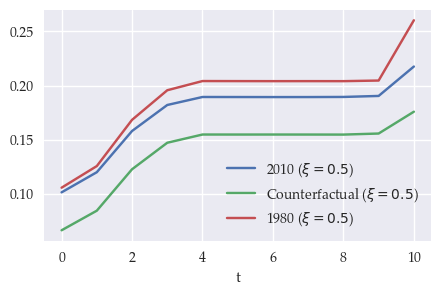

In [11]:
idxmin = np.argmin([abs(sols2010[ξ]['τ'].xs(m2010.db['t0'])-solsCF[ξ]['τ'].xs(m2010.db['t0'])) for ξ in sols2010])
ξ = list(sols2010.keys())[idxmin]
# ξ = .25
pd.concat([sols2010[ξ]['τ'].rename(f"""2010 ($\\xi ={ξ}$)"""), solsCF[ξ]['τ'].rename(f"""Counterfactual ($\\xi ={ξ}$)"""),
           sols1980[ξ]['τ'].rename(f"""1980 ($\\xi ={ξ}$)""")], axis = 1).plot(figsize=(5,3))

Plot for some other level:

<Axes: xlabel='t'>

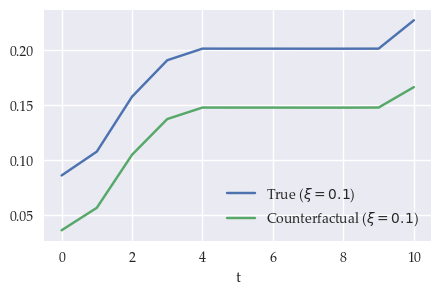

In [12]:
ξ = .1
pd.concat([sols2010[ξ]['τ'].rename(f"""True ($\\xi ={ξ}$)"""), solsCF[ξ]['τ'].rename(f"""Counterfactual ($\\xi ={ξ}$)""") ], axis = 1).plot(figsize=(5,3))

#### 2.3. Set up 1980 model and solve *without* endogenous $\kappa$:

In [13]:
solsCF_fixedκ = dict.fromkeys(pars2010)
for k,v in pars2010.items():
    mCF.db['ξ'] = k
    mCF.US_Xi() # update Xi after updating ξ
    mCF.db['ρ'] = v['ρ']
    mCF.db['ω'] = v['ω']
    mCF.db['βi'] = mCF.US_β(v['β'])
    mCF.db['κ'] = sols2010[k]['κ'].copy()
    mCF.db['κ[t+1]'] = sols2010[k]['κ[t+1]'].copy()
    solsCF_fixedκ[k] = mCF.PEE_FH()

Compare again:

<Axes: xlabel='t'>

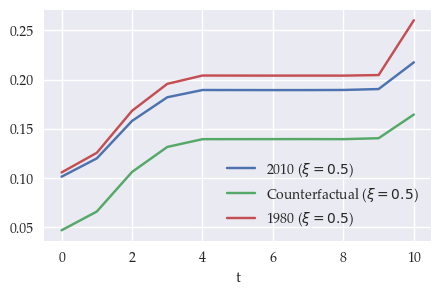

In [14]:
idxmin = np.argmin([abs(sols2010[ξ]['τ'].xs(m2010.db['t0'])-solsCF_fixedκ[ξ]['τ'].xs(m2010.db['t0'])) for ξ in sols2010])
ξ = list(sols2010.keys())[idxmin]
# ξ = .25
pd.concat([sols2010[ξ]['τ'].rename(f"""2010 ($\\xi ={ξ}$)"""), solsCF_fixedκ[ξ]['τ'].rename(f"""Counterfactual ($\\xi ={ξ}$)"""),
           sols1980[ξ]['τ'].rename(f"""1980 ($\\xi ={ξ}$)""")], axis = 1).plot(figsize=(5,3))